# Mask R-CNN - Train on Miami Buildings Dataset




In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
DATA_PATH = "/data/RCNNTanks256Train/Yanbu"

IMG_SIZE = 256

Using TensorFlow backend.


In [2]:
# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
import keras 

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

## Configurations

In [3]:
class MiamiConfig(Config):
    """Configuration for training on the Miami buildings dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "tank"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = IMG_SIZE
    IMAGE_MAX_DIM = IMG_SIZE

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  
    RPN_ANCHOR_SCALES = (10, 20, 40, 80, 160)  
    
    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
#     RPN_ANCHOR_RATIOS = [0.25, 1, 4]
    
    
    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
#     LOSS_WEIGHTS = {
#         "rpn_class_loss": 1.,
#         "rpn_bbox_loss": 1.,
#         "mrcnn_class_loss": 1.,
#         "mrcnn_bbox_loss": 1.,
#         "mrcnn_mask_loss": 1.1
#     }    

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 256
    
#     ROI_POSITIVE_RATIO = 0.5 #makes no positive effect

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1
    
    # Image mean (RGB)
    MEAN_PIXEL = np.array([131.84381436753546, 125.43039054432134, 113.32320930217874]) 


    
config = MiamiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax, fig

## Dataset

Load Miami dataset

Extend the Dataset class and add a method to load the dataset, `load()`, and override the following methods:

* load_mask()
* image_reference()

In [5]:
import glob
import skimage

class MiamiDataset(utils.Dataset):

    def load(self, dataset_dir):
        # Add classes
        self.add_class("tank", 1, "Tank")
        
        #loading images
        self._image_dir = os.path.join(dataset_dir, "images/")
        self._mask_dir = os.path.join(dataset_dir, "labels/")
        for i, f in enumerate(glob.glob(os.path.join(self._image_dir, "*.tif"))):
            _, filename = os.path.split(f)
            self.add_image("tank",
                           image_id=i,
                           path=f,
                           width=config.IMAGE_MAX_DIM,
                           height=config.IMAGE_MAX_DIM,
                           filename=filename)
            
    def load_mask(self, image_id):
        """Read instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        fname = info["filename"]
        masks = []
        class_ids = []
        #looping through all the classes, loading and processing corresponding masks
        for ci in self.class_info:
            class_name = ci["name"]
            class_id = ci["id"]
            try:
                m_src = skimage.io.imread(os.path.join(self._mask_dir, class_name, fname))
            except:
                #no file with masks of this class found
                continue                
            #making individual masks for each instance
            instance_ids = np.unique(m_src)
            for i in instance_ids:
                if i > 0:
                    m = np.zeros(m_src.shape)
                    m[m_src==i] = i
                    if np.any(m==i):
                        masks.append(m)
                        class_ids.append(class_id)
        try:
            masks = np.stack(masks, axis=-1)        
        except:
            print("!!! no masks were found.", info)
            
        # Return mask, and array of class IDs of each instance.
        return masks.astype(np.bool), np.array(class_ids, dtype=np.int32)
        
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tank":
            return info["tank"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [6]:
# Training dataset
dataset_train = MiamiDataset()
dataset_train.load(os.path.join(DATA_PATH, "20150602_083117"))
dataset_train.prepare()

# Validation dataset
dataset_val = MiamiDataset()
dataset_val.load(os.path.join(DATA_PATH, "20151026_082156"))
dataset_val.prepare()

# Test dataset
dataset_test = MiamiDataset()
dataset_test.load(os.path.join(DATA_PATH, "20151226_085413"))
dataset_test.prepare()

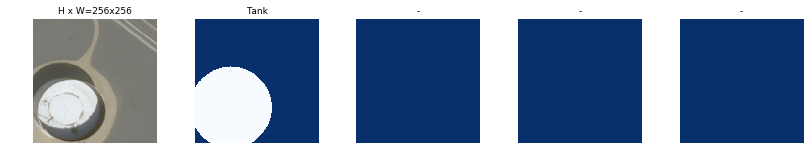

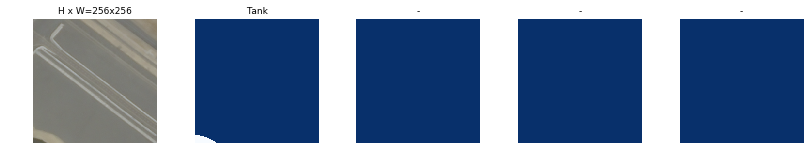

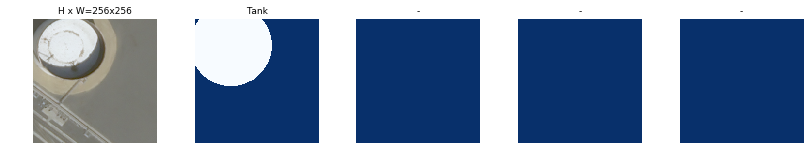

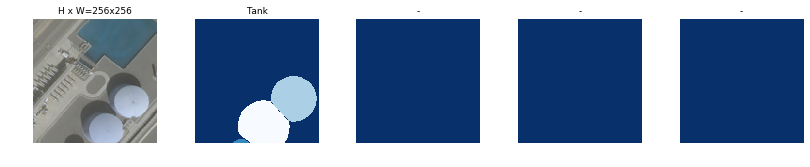

In [10]:
# Load and display random samples
dataset = dataset_test
image_ids = np.random.choice(dataset.image_ids, 4)

# for ii in dataset.image_info:
#     if ii['filename'] == '000005160.tif':
#         image_ids = [ii['id']]
#         break

for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    #print(dataset.image_info[image_id]["filename"])
    #log("mask", mask)
    #log("class_ids", class_ids)
    #print(class_ids)

## Ceate Model

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training",
                          config=config,
                          model_dir=MODEL_DIR)

In [12]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits",
                                "mrcnn_bbox_fc", 
                                "mrcnn_bbox",
                                "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model_path = model.find_last()[1]
#     model_path="/home/dkudinov/TF/VASYA/projects/RemoteSensing/BuildingDetection/projects/Miami/Mask_RCNN/logs/r5_imgaug_roi1000_20180608T1627/mask_rcnn_r5_imgaug_roi1000__0800.h5"
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

94658560/94653016 [==============================] - 3s 0us/step


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=90,
            layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /Mask_RCNN/logs/tank20190505T1119/mask_rcnn_tank_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/90
100/100 [==============================] - 110s 1s/step - loss: 3.6578 - rpn_class_loss: 0.3060 - rpn_bbox_loss: 1.7499 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.8402 - mrcnn_mask_loss: 0.5919 - val_loss: 5.4734 - val_rpn_class_loss: 0.1006 - val_rpn_bbox_loss: 4.0044 - val_mrcnn_class_loss: 0.0292 - val_mrcnn_bbox_loss: 0.6970 - val_mrcnn_mask_loss: 0.6421
Epoch 2/90
100/100 [==============================] - 92s 920ms/step - loss: 2.7096 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.6849 - mrcnn_mask_loss: 0.6055 - val_loss: 5.3850 - val_rpn_class_loss: 0.0836 - val_rpn_bbox_loss: 4.0157 - val_mrcnn_class_loss: 0.0457 - val_mrcnn_bbox_loss: 0.6162 - val_mrcnn_mask_loss: 0.6238
Epoch 3/90
100/100 [==============================] - 92s 923ms/step - loss: 2.4347 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.0548 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.6377 - mrcnn_mask_loss: 0.6183 - val_loss: 5.2236 - val_rpn_cla

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)


## Detection

In [ ]:
class InferenceConfig(MiamiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()
# model_path = os.path.join(ROOT_DIR, "./logs/r5_imgaug_roi1000_20180608T1627/mask_rcnn_r5_imgaug_roi1000__0570.h5")

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
dataset = dataset_test

image_id = random.choice(dataset.image_ids)

# for ii in dataset.image_info:
#     if ii['filename'] == '000005160.tif':
#         image_id = ii['id']
#         break

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)
# print("image_id: ", image_id)
# print(dataset.image_info[image_id])

results = model.detect([original_image], verbose=1)
r = results[0]
#if r["masks"].shape[2] > 0:
#    log("masks", r["masks"])

ax, fig = get_ax(1,2)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=ax[0])

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax[1])

AP, precisions, recalls, overlaps =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'])
print(AP)    

In [ ]:
fig.savefig("tank1.png")

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
dataset = dataset_val
image_ids = dataset.image_ids
APs = []
pss = []
rcs = []
ops = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    pss.append(precisions)
    rcs.append(recalls)
    ops.append(overlaps)
    
print("mAP: ", np.mean(APs))